In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import regex as re

In [ ]:
k = 31

### AalbF5 chromosome 1
# based on fasta file
nb_nucleotides = 338_177_654    # grep -v '^>' AalbF5_chr1.fna | tr -d '\n' | wc -c     # coincides exactly with NCBI indication
nb_ACGT = 155_552_214           # grep -v '^>' AalbF5_chr1.fna | tr -cd ACGT | wc -c
nb_acgt = 182_182_218           # grep -v '^>' AalbF5_chr1.fna | tr -cd acgt | wc -c
nb_N = 443_222                  # grep -v '^>' AalbF5_chr1.fna | tr -cd N | wc -c

nb_patches_N = 8562             # grep -v '^>' AalbF5_chr1.fna | grep -oP 'N+'| wc -l   # note: pb with patches gapping lines/ at start or end of seq

# based on rust code
nb_total_31mers = 337_698_822   # with duplicates           # coincides ~ with: nb_nucleotides - nb_N - (k-1) * (nb_patches_N+1)
nb_nocan_31mers = 247_347_254   # without duplicates
nb_canon_31mers = 232_971_101   # without duplicates

### graph AalbF3 + AalbF5 (k31, canonical)
nb_nodes = 376_592_961
nb_edges = 383_504_450

### graph AalbF5 (k31, canonical)
nb_nodes = 232_971_101
nb_edges = 236_446_568

### graph AalbF5 (k32, canonical)
nb_nodes = 235_350_021

### walktrough of AalbF5 (canonical)
nb_breaks_one_haplo = 46_619_218
nb_breaks_two_haplo = 55_574_344


In [ ]:
# Input graph: only AalbF3
#   - 255874974 nodes
#   - 259767078 edges
# Haplo contains:
#   - kmers: 373823221
#   - breakpoints: 52598113  (>1)      217  (<1)

# Input graph: only AalbF5
#   - 232971101 nodes
#   - 236446568 edges
# Haplo contains:
#   - kmers: 337698822
#   - breakpoints: 46619218  (>1)      862  (<1)

# Input graph: both haplo
#    - 376592961 nodes
#    - 383504450 edges
# Haplo AalbF3 contains:
#    - 373823221 kmers
#    - breakpoints: 60820242  (>1)     188  (<1)
# Haplo AalbF5 contains:
#    - 337698822 kmers
#    - breakpoints: 55574344  (>1)     470  (<1)

In [2]:
def parse_fasta(fasta_file):
    """Parse FASTA file into a dictionary of {header: sequence}"""
    headers = []
    length = []
    current_header = None
    current_sequence = []
    
    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                # If we were working on a sequence, save it
                if current_header is not None:
                    current_sequence = ''.join(current_sequence)
                    headers.append(current_header)
                    length.append(len(current_sequence))
                
                # Start a new sequence
                current_header = line[1:]  # Remove the '>' character
                current_sequence = []
            elif line:
                current_sequence.append(line)
    
    # Don't forget to save the last sequence
    if current_header is not None:
        current_sequence = ''.join(current_sequence)
        headers.append(current_header)
        length.append(len(current_sequence))
    
    return headers, length

In [3]:
def parse_headers(headers):
    pattern = r'^(.*?)\tlen: (\d+)\tdone in: ([\d.]+)s$'

    data = [re.match(pattern, entry).groups() for entry in headers]

    # Create DataFrame from the extracted groups
    df = pd.DataFrame(data, columns=['ID', 'Path length', 'Time'])

    # Convert columns to appropriate types
    df['Path length'] = df['Path length'].astype(int)
    df['Time'] = df['Time'].astype(float)

    return df

In [4]:
input_fasta = "input/chr1/AalbF5_splitN.fna"
output_fasta = "output/chr1/path.AalbF5_splitN.fna"

In [5]:
# input
headers_i, lengths_i = parse_fasta(input_fasta)
df_i = pd.DataFrame({'ID': headers_i, 'Seq length': lengths_i})
df_i['Seq length'] = df_i['Seq length'].astype(int)

# output
headers_o, length_o = parse_fasta(output_fasta)
df_o = parse_headers(headers_o)

# both
df = pd.merge(df_i, df_o, on='ID', how='inner')
df

,ID,Seq length,Path length,Time
0,AalbF5#1#chr1_1,25000,1591,307.559477
1,AalbF5#1#chr1_2,25000,1914,345.085072
2,AalbF5#1#chr1_3,25000,471,141.957242
3,AalbF5#1#chr1_4,75000,518,77.756679
4,AalbF5#1#chr1_5,25000,178,5.230052
...,...,...,...,...
236,AalbF5#1#chr1_237,575000,1726,293.767813
237,AalbF5#1#chr1_238,175000,514,195.102436
238,AalbF5#1#chr1_239,278981,1744,138.462155
239,AalbF5#1#chr1_240,967226,916,273.071738


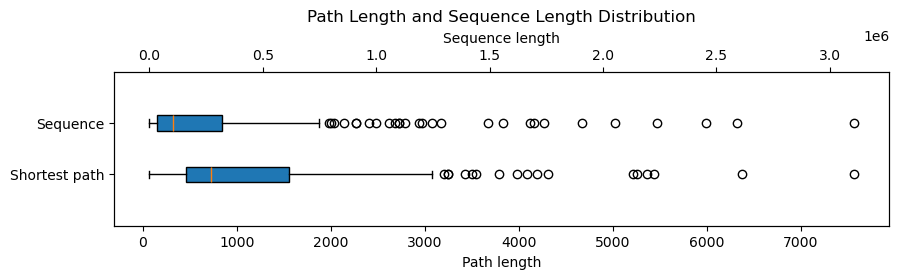

In [6]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 2)

# Boxplot for Path length
ax1.boxplot(df['Path length'], vert=False, patch_artist=True)
ax1.set_xlabel('Path length')
ax1.set_title('Path Length and Sequence Length Distribution')

# Secondary x-axis for Sequence length
ax2 = ax1.twiny()
ax2.boxplot(df['Seq length'], vert=False, patch_artist=True, positions=[1.5])
ax2.set_xlabel('Sequence length')

ax1.set_yticks([1, 1.5])
ax1.set_yticklabels(['Shortest path', 'Sequence'])

# plt.tight_layout()
plt.show()

In [12]:
print("   For shortest path")
print(f"Mean length: {df['Path length'].mean()}")
print(f"Median: {df["Path length"].median()}")

print("   For sequence")
print(f"Mean length: {df['Seq length'].mean()}")
print(f"Median: {df["Seq length"].median()}")

   For shortest path
Mean length: 1186.9253112033196
Median: 724.0
   For sequence
Mean length: 307306.6929460581
Median: 101776.0


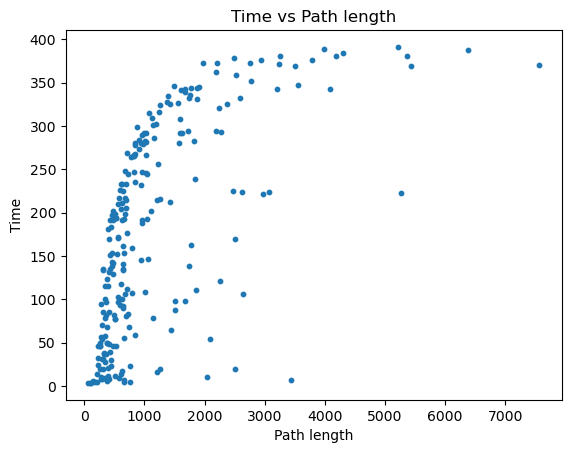

In [8]:
plt.scatter(df['Path length'], df['Time'], s=10)
plt.xlabel('Path length')
plt.ylabel('Time')
plt.title('Time vs Path length')
plt.show()

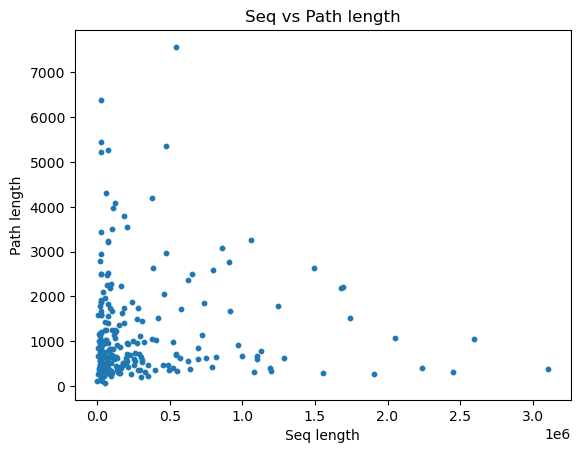

In [9]:
plt.scatter(df['Seq length'], df['Path length'], s=10)
plt.xlabel('Seq length')
plt.ylabel('Path length')
plt.title('Seq vs Path length')
plt.show()